In [32]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import os
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
unique_breeds=np.array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
       'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael',
       'ibizan_hound', 'irish_setter', 'irish_terrier',
       'irish_water_spaniel', 'irish_wolfhound', 'italian_greyhound',
       'japanese_spaniel', 'keeshond', 'kelpie', 'kerry_blue_terrier',
       'komondor', 'kuvasz', 'labrador_retriever', 'lakeland_terrier',
       'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese_dog',
       'mexican_hairless', 'miniature_pinscher', 'miniature_poodle',
       'miniature_schnauzer', 'newfoundland', 'norfolk_terrier',
       'norwegian_elkhound', 'norwich_terrier', 'old_english_sheepdog',
       'otterhound', 'papillon', 'pekinese', 'pembroke', 'pomeranian',
       'pug', 'redbone', 'rhodesian_ridgeback', 'rottweiler',
       'saint_bernard', 'saluki', 'samoyed', 'schipperke',
       'scotch_terrier', 'scottish_deerhound', 'sealyham_terrier',
       'shetland_sheepdog', 'shih-tzu', 'siberian_husky', 'silky_terrier',
       'soft-coated_wheaten_terrier', 'staffordshire_bullterrier',
       'standard_poodle', 'standard_schnauzer', 'sussex_spaniel',
       'tibetan_mastiff', 'tibetan_terrier', 'toy_poodle', 'toy_terrier',
       'vizsla', 'walker_hound', 'weimaraner', 'welsh_springer_spaniel',
       'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'])

In [3]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224) for efficient training
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [4]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [28]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [5]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [6]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [10]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Dog_Breed/Dog Vision/models/20240609-09571717927062-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /content/drive/MyDrive/Dog_Breed/Dog Vision/models/20240609-09571717927062-full-image-set-mobilenetv2-Adam.h5


In [17]:
# Give the path to your custom dog Images Folder.
custom_path = "/content/drive/MyDrive/Dog_Breed/CustomImgs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [18]:
custom_image_paths

['/content/drive/MyDrive/Dog_Breed/CustomImgs/boxer.jpg',
 '/content/drive/MyDrive/Dog_Breed/CustomImgs/Dhole.jpg',
 '/content/drive/MyDrive/Dog_Breed/CustomImgs/Papillon.jpg',
 '/content/drive/MyDrive/Dog_Breed/CustomImgs/toy-poodle.jpg']

In [19]:
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [21]:
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 340ms/step


In [34]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [37]:
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

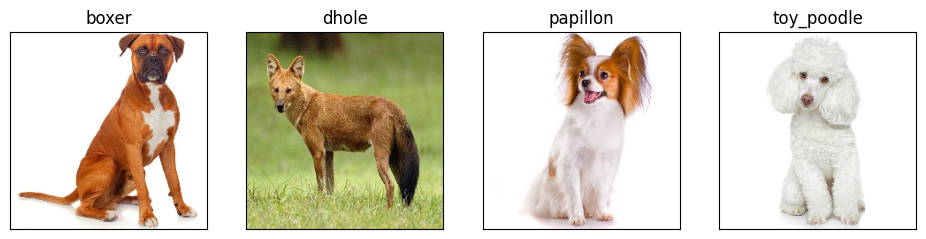

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
for i, image in enumerate(custom_images):
  plt.subplot(1, 10 , i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)